验证集

K折交叉验证（数据不够时）

下面通过拟合多项式回归，来探讨欠拟合和过拟合问题

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # `gamma(n)` = (n-1)!
# `labels`的维度: (`n_train` + `n_test`,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [3]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    d2l.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.2295],
         [ 1.7429]]),
 tensor([[ 1.0000e+00, -2.2946e-01,  2.6326e-02, -2.0136e-03,  1.1551e-04,
          -5.3008e-06,  2.0272e-07, -6.6451e-09,  1.9060e-10, -4.8594e-12,
           1.1150e-13, -2.3259e-15,  4.4475e-17, -7.8502e-19,  1.2866e-20,
          -1.9682e-22,  2.8226e-24, -3.8099e-26,  4.8567e-28, -5.8654e-30],
         [ 1.0000e+00,  1.7429e+00,  1.5188e+00,  8.8237e-01,  3.8447e-01,
           1.3402e-01,  3.8929e-02,  9.6926e-03,  2.1116e-03,  4.0892e-04,
           7.1271e-05,  1.1292e-05,  1.6401e-06,  2.1988e-07,  2.7374e-08,
           3.1806e-09,  3.4646e-10,  3.5520e-11,  3.4393e-12,  3.1549e-13]]),
 tensor([4.5669, 6.6375]))

In [4]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失。"""
    metric = d2l.Accumulator(2)  # 损失的总和, 样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [5]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式特征中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 5.012354   1.2006766 -3.4067647  5.5981016]]


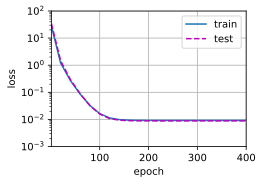

In [6]:
# 从多项式特征中选择前4个维度，即 1, x, x^2/2!, x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[3.4436884 4.3683476]]


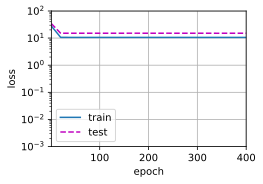

In [7]:
# 从多项式特征中选择前2个维度，即 1, x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])
# 在最后一个迭代周期完成后，训练损失仍然很高，模型欠拟合

weight: [[ 4.9934835e+00  1.3279551e+00 -3.2717242e+00  5.0006905e+00
  -4.3908432e-01  1.3309754e+00  1.7214179e-01  3.2818848e-01
   2.7744470e-03  2.0750052e-01 -8.4267549e-02 -1.6561596e-01
   7.6970860e-02 -1.9354300e-01  2.1866712e-01 -3.5764023e-03
   1.7296565e-01  2.0191681e-02  4.4315349e-02  2.0523429e-01]]


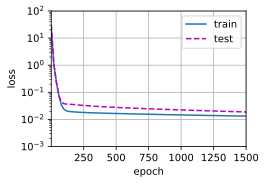

In [8]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)
# 过于复杂的模型会轻易受到训练数据中噪声的影响。虽然训练损失依旧可以有效地降低，但测试损失仍然很高
# 模型过拟合